# Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import utils, models, layers, optimizers

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

# Exercise 9:

**Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.**

In [3]:
DOWNLOAD_ROOT = 'http://download.tensorflow.org/data/'
FILENAME = 'quickdraw_tutorial_dataset_v1.tar.gz'
CACHE_DIR = os.path.join(os.path.expanduser('~'), 'Developer', 'Datasets', 'QuickDraw', 'Raw')

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

filepath = utils.get_file(FILENAME,
                          DOWNLOAD_ROOT + FILENAME,
                          cache_subdir = CACHE_DIR,
                          extract = True)

In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')])

print(train_files)
print(eval_files)

['/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00000-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00001-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00002-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00003-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00004-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00005-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00006-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00007-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00008-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/training.tfrecord-00009-of-00010']
['/Users/mmenendezg/Developer/Datasets/QuickDraw/Raw/eval.tfrecord-00000-of-00010', '/Users/mmenendezg/Developer/Datasets/QuickDr

In [5]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / 'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()
    
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [6]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [7]:
def parse(data_batch):
    feature_descriptions = {
        'ink' : tf.io.VarLenFeature(dtype=tf.float32),
        'shape' : tf.io.FixedLenFeature([2], dtype=tf.int64),
        'class_index' : tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [16]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None, cache=False):
    
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=AUTOTUNE)
    
    if cache:
        dataset.cache()
    if shuffle_buffer_size:
        dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)

In [17]:
# Load the data
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [18]:
for sketches, lenghts, labels in train_set.take(1):
    print(f'Sketches = {sketches}')
    print(f'Lengths = {lenghts}')
    print(f'Labels = {labels}')

Sketches = [[[ 0.01968503  0.05095541  0.        ]
  [ 0.03149611  0.03184712  0.        ]
  [ 0.12204725 -0.01273882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.15686277  0.          0.        ]
  [-0.04705882  0.01851851  0.        ]
  [-0.09411766  0.05555555  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.09842521  0.0608108   0.        ]
  [-0.09842519  0.09459461  0.        ]
  [-0.09055118  0.14864865  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.10980393  0.          0.        ]
  [ 0.19607845  0.0443038   0.        ]
  [ 0.03137255  0.01265822  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.   

In [19]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], '.-')
    plt.axis('off')

def draw_sketches(sketches, lenghts, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, lenght, label in zip(range(n_sketches), sketches, lenghts, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:lenght], label)
    plt.show()

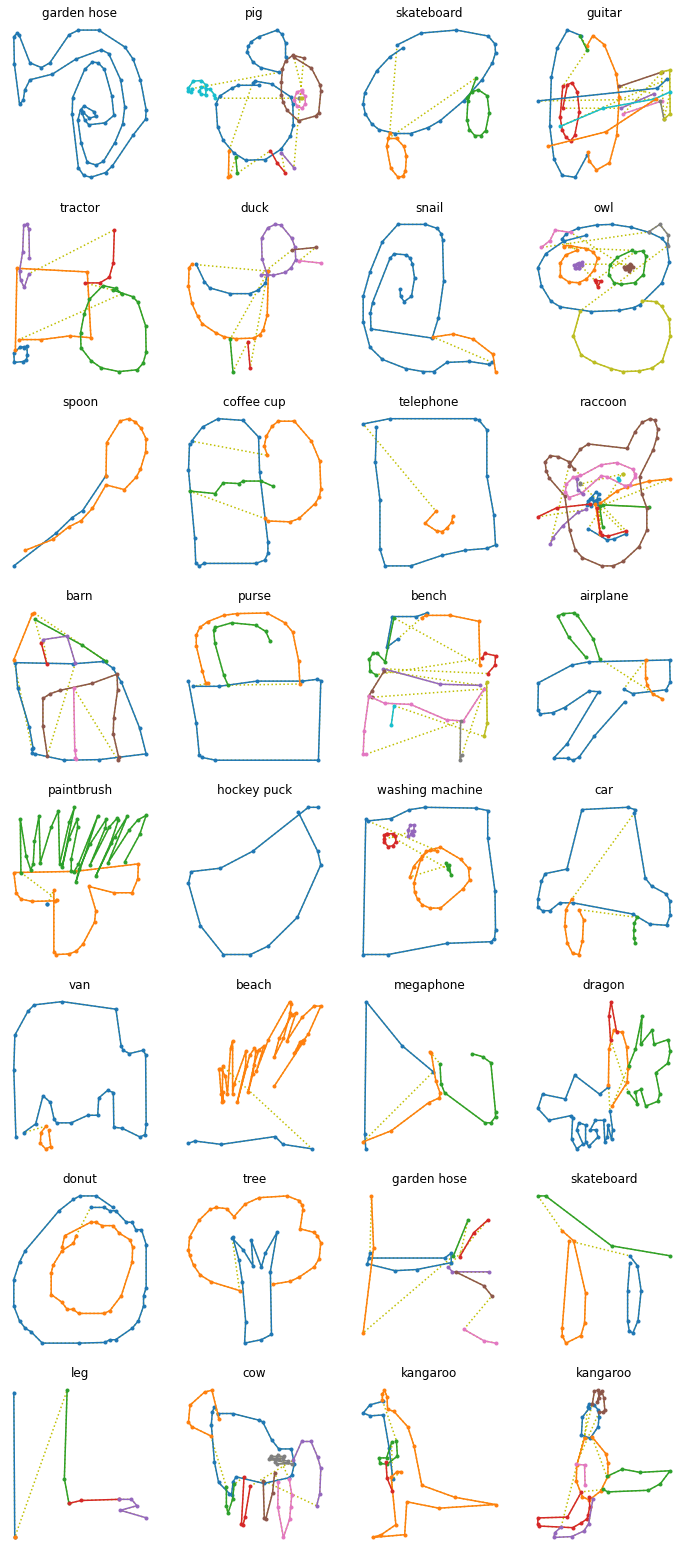

In [20]:
for sketches, lenghts, labels in train_set.take(1):
    draw_sketches(sketches, lenghts, labels)

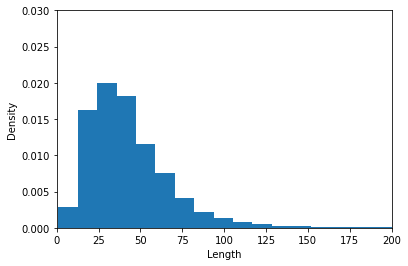

In [21]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel('Length')
plt.ylabel('Density')
plt.show()

In [22]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [23]:
model = models.Sequential([
    layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=5, strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(len(class_names), activation='softmax')
])

optimizer = optimizers.SGD(learning_rate=1e-3, clipnorm=1.)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy', 'sparse_top_k_categorical_accuracy'])

history = model.fit(cropped_train_set,
                    validation_data = cropped_valid_set,
                    epochs=10)

Epoch 1/10


2022-03-04 16:08:30.610550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 16:08:31.697899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 16:08:31.877127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 16:08:31.961396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 16:08:32.262642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  44692/Unknown - 1603s 36ms/step - loss: 5.7661 - accuracy: 0.0062 - sparse_top_k_categorical_accuracy: 0.0296

KeyboardInterrupt: 

# Exercise 10:

**Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out Google’s Coconet model, which was used for a nice Google doodle about Bach.**